In [1]:
# pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [3]:
df=pd.read_excel('Gold_data.xlsx')
df.head()

date    price
0 2016-01-01  2252.60
1 2016-01-02  2454.50
2 2016-01-03  2708.10
3 2016-01-04  2577.80
4 2016-01-05  2597.75

In [4]:
df.set_index('date',inplace=True)
df.head()

price
date               
2016-01-01  2252.60
2016-01-02  2454.50
2016-01-03  2708.10
2016-01-04  2577.80
2016-01-05  2597.75

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2182 entries, 2016-01-01 to 2021-12-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2182 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


In [6]:
df.describe()

price
count  2182.000000
mean   3284.450046
std     719.564434
min    2252.600000
25%    2697.020000
50%    2879.800000
75%    4147.325000
max    4966.300000

<AxesSubplot:xlabel='date'>

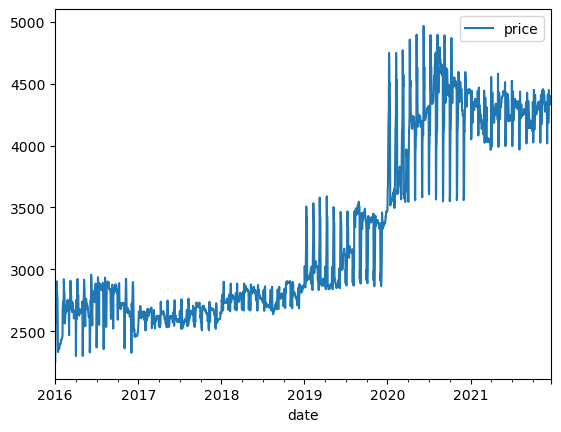

In [7]:
df.plot()

<AxesSubplot:xlabel='price', ylabel='Density'>

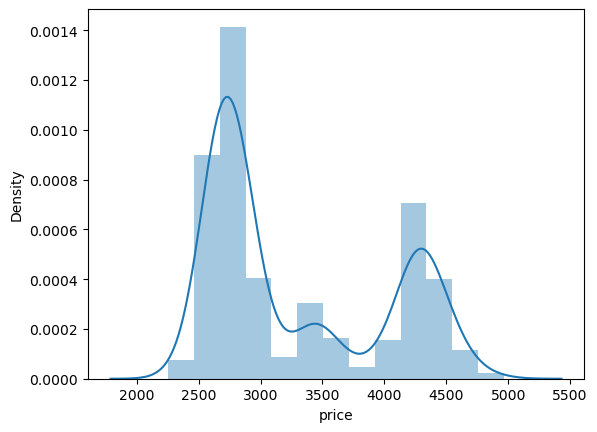

In [8]:
sns.distplot(df['price'])

In [9]:
# Augmented Dickey-Fuller Test:
result=adfuller (df['price'])
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))
        
p=result[1]

if p>0.05:
    print('the data set not stationary')
else:
    print('the data set is stationary')


Test Statistic: -0.309904
p-value: 0.924090
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
the data set not stationary


In [10]:
# convert the non- stationary to stationary data
df_log=np.log(df['price'])
df['price_diff']=df_log.diff()

In [11]:
df.isna().sum()

price         0
price_diff    1
dtype: int64

In [12]:
df.dropna(inplace=True)

In [13]:
# Augmented Dickey-Fuller Test:
result=adfuller (df['price_diff'])
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))
        
p=result[1]

if p>0.05:
    print('the data set not stationary')
else:
    print('the data set is stationary')


Test Statistic: -21.394232
p-value: 0.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
the data set is stationary


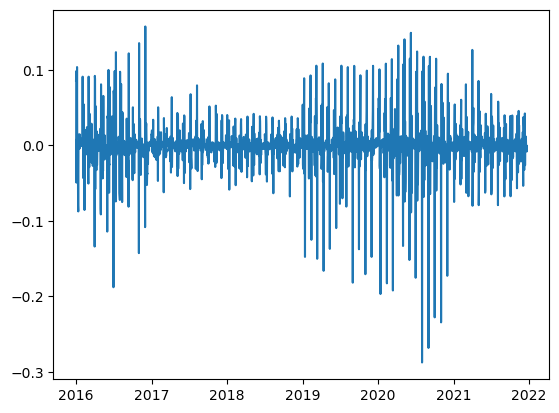

In [14]:
plt.plot(df['price_diff'])

# Forecasting on SARIMAX

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

In [16]:
# fit auto_arima function to gold price datast
from pmdarima import auto_arima
stepwise_fit=auto_arima(df['price_diff'],start_p=1,start_q=1,
                       max_p=3,max_q=3,m=12,
                       start_P=0,seasonal=True,
                       d=None,D=1,trace=True,
                        error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=11.53 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-7252.754, Time=0.63 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-7702.421, Time=4.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=12.32 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-7254.754, Time=0.17 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-7252.395, Time=1.40 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-8010.765, Time=11.18 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=23.15 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.17 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-8010.643, Time=7.31 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-8030.199, Time=26.23 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-7729.747, Time=5.21 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=27.14 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=13.11 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept

In [17]:
# split the data into test/train set
train=df.iloc[:len(df)-365]
test=df.iloc[len(df)-365:] # set one year(12 months) for testing

In [18]:
#Fit a SARIMAX(2,0,0)x(2,1,0,12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['price'],order = (2, 0, 0), seasonal_order =(2, 1, 0, 12))
result = model.fit()
result.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                 1816
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood              -11350.999
Date:                            Wed, 07 Dec 2022   AIC                          22711.997
Time:                                    17:02:01   BIC                          22739.486
Sample:                                01-02-2016   HQIC                         22722.143
                                     - 12-21-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9332      0.018     52.366      0.000       0.898       0.968
ar.L2         -0.1638      0.019     -8.655      0.000      -0.201      -0.127
ar.S.L12      -0.5985      0.012    -51.228      0.000      -0.621      -0.576
ar.S.L24      -0.3834      0.011    -34.304      0.000      -0.405      -0.362
sigma2      1.701e+04    210.211     80.906      0.000    1.66e+04    1.74e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             27209.33
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               5.00   Skew:                            -1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# prediction of ARIMA model against the test set
start=len(train)
end=len(train)+len(test)-1

In [20]:
# Predictions for one-year against the test set
predictions = result.predict(start, end, typ = 'levels').rename("Predictions")

In [21]:
predictions

2020-12-22    4439.672490
2020-12-23    4434.632774
2020-12-24    4359.727745
2020-12-25    4209.247248
2020-12-26    4207.803080
                 ...     
2021-12-17    4427.492353
2021-12-18    4416.165943
2021-12-19    4333.293356
2021-12-20    4127.565721
2021-12-21    4118.670034
Freq: D, Name: Predictions, Length: 365, dtype: float64

<AxesSubplot:xlabel='date'>

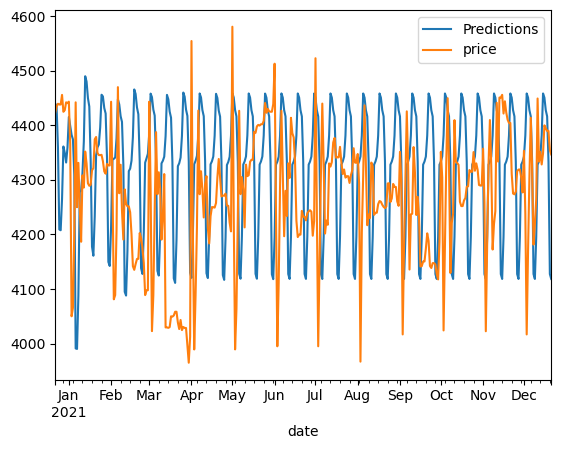

In [22]:
# plot predictions and actual values
predictions.plot(legend = True)
test['price'].plot(legend = True)

In [23]:
#Forecast using ARIMA Model
# Train the model on the full dataset
model = model = SARIMAX(df['price'], 
                        order = (2, 0, 0), 
                        seasonal_order =(2, 1, 0, 12))
result = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [24]:
# Forecast for the next 30 days
forecast = result.predict(start = len(df), 
                          end = (len(df)-1) + 1 * 30, 
                          typ = 'levels').rename('Forecast 30 days')

<AxesSubplot:xlabel='date'>

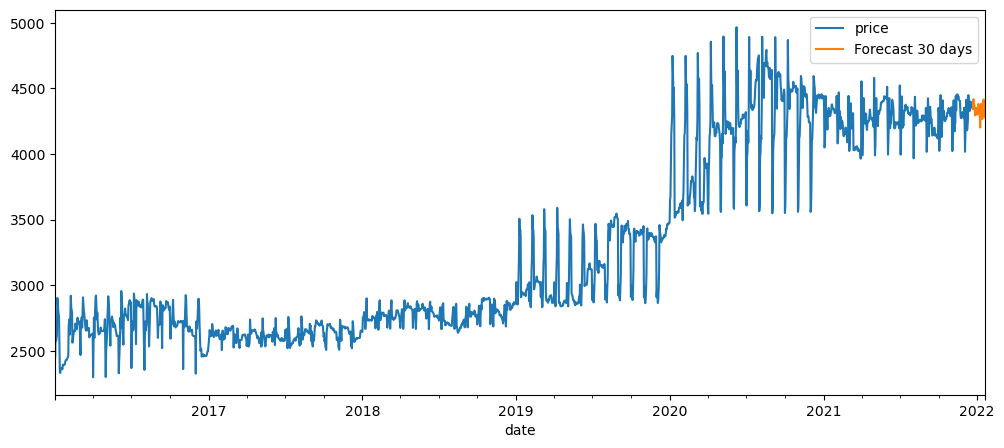

In [25]:
# Plot the forecast values
df['price'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

In [26]:
# Load specific evaluation tools
from statsmodels.tools.eval_measures import rmse
rmse_sarimax=rmse(test["price"], predictions)

# Calculate root mean squared error
print('RMSE of the gold price:',rmse_sarimax)

RMSE of the gold price: 175.5592039663265


# CROSS-VERIFYING

In [27]:
# Split data into train / test sets
train1 = df.iloc[:len(df)-730]
test1 = df.iloc[len(df)-730:] # set two year(24 months) for testing

In [28]:
# prediction of SARIMA model against the test set
start1=len(train1)
end1=len(train1)+len(test1)-1

In [29]:
# Predictions for 2-year against the test set
predictions1 = result.predict(start1, end1, typ = 'levels').rename("Predictions1")

<AxesSubplot:xlabel='date'>

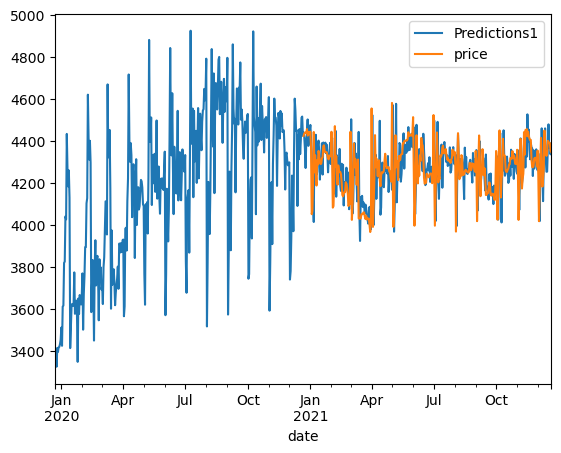

In [30]:
# plot predictions and actual values
predictions1.plot(legend = True)
test['price'].plot(legend = True)

# prophet model

In [31]:
# !pip install prophet

In [32]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
dt=pd.read_excel('Gold_data.xlsx')

In [34]:
dt['date'] = pd.to_datetime(dt ['date'])

In [35]:
dt.columns = ['ds', 'y']
dt.head()

ds        y
0 2016-01-01  2252.60
1 2016-01-02  2454.50
2 2016-01-03  2708.10
3 2016-01-04  2577.80
4 2016-01-05  2597.75

In [36]:
# model develpment
p= Prophet(interval_width=0.80, daily_seasonality=True)
model = p.fit(dt)

17:02:09 - cmdstanpy - INFO - Chain [1] start processing
17:02:10 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# genarete the next 30 day  dates
future = p.make_future_dataframe(periods=30, freq='D')
future.tail(30)

ds
2182 2021-12-22
2183 2021-12-23
2184 2021-12-24
2185 2021-12-25
2186 2021-12-26
2187 2021-12-27
2188 2021-12-28
2189 2021-12-29
2190 2021-12-30
2191 2021-12-31
2192 2022-01-01
2193 2022-01-02
2194 2022-01-03
2195 2022-01-04
2196 2022-01-05
2197 2022-01-06
2198 2022-01-07
2199 2022-01-08
2200 2022-01-09
2201 2022-01-10
2202 2022-01-11
2203 2022-01-12
2204 2022-01-13
2205 2022-01-14
2206 2022-01-15
2207 2022-01-16
2208 2022-01-17
2209 2022-01-18
2210 2022-01-19
2211 2022-01-20

In [38]:
# forecasting the next 30 days
forecast_prediction = p.predict(future)
forecast_prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

ds         yhat   yhat_lower   yhat_upper
2182 2021-12-22  4210.128530  3982.346530  4422.090054
2183 2021-12-23  4220.227658  4001.355976  4453.780214
2184 2021-12-24  4224.236555  4012.881846  4437.266443
2185 2021-12-25  4238.363944  4033.842388  4452.162496
2186 2021-12-26  4244.844459  4030.014504  4456.692591
2187 2021-12-27  4255.069226  4059.648100  4477.203271
2188 2021-12-28  4264.191151  4041.832694  4477.654610
2189 2021-12-29  4271.390260  4066.313535  4482.220600
2190 2021-12-30  4278.914566  4072.927798  4499.325534
2191 2021-12-31  4279.454892  4058.760564  4468.601113
2192 2022-01-01  4289.291348  4077.587521  4484.586206
2193 2022-01-02  4290.746777  4073.716164  4505.978331
2194 2022-01-03  4295.315340  4086.366055  4492.143740
2195 2022-01-04  4298.265481  4077.113967  4506.580064
2196 2022-01-05  4298.902657  4096.781379  4522.653606
2197 2022-01-06  4299.607386  4084.659736  4521.241290
2198 2022-01-07  4293.207099  4090.715269  4509.703910
2199 2022-01-08  4296.119577  4078.971995  4512.822501
2200 2022-01-09  4290.803353  4059.243474  4496.387770
2201 2022-01-10  4288.883332  4062.172700  4490.195566
2202 2022-01-11  4285.750927  4067.685951  4490.684529
2203 2022-01-12  4280.824185  4068.378629  4482.413468
2204 2022-01-13  4276.583484  4051.341982  4505.473358
2205 2022-01-14  4265.941375  4044.138514  4478.494966
2206 2022-01-15  4265.384368  4045.899877  4469.332730
2207 2022-01-16  4257.422085  4038.944354  4485.303971
2208 2022-01-17  4253.712067  4038.527635  4488.719899
2209 2022-01-18  4249.659529  4029.359667  4458.139075
2210 2022-01-19  4244.677541  4028.157950  4461.398522
2211 2022-01-20  4241.223230  4018.571973  4460.642408

In [39]:
# plot the forecasting gold price
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(p,forecast_prediction)

In [40]:
# plot the model componets
plot_components_plotly(p, forecast_prediction)

In [41]:
import math
#mean square error
MSE = np.square(np.subtract(dt['y'],forecast_prediction['yhat'])).mean() 
# root mean square
RMSE_prophet = math.sqrt(MSE)
print("Root Mean Square Error of gold price:\n")
print(RMSE_prophet)

Root Mean Square Error of gold price:

168.82241507026177


# Darts librery

In [42]:
# pip install darts

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries

In [44]:
gold=pd.read_excel('Gold_data.xlsx')

In [45]:
# convert the gold data set into the Timeseries
df_series=TimeSeries.from_dataframe(gold, 'date', 'price')

In [46]:
df_series

<TimeSeries (DataArray) (date: 2182, component: 1, sample: 1)>
array([[[2252.6]],

       [[2454.5]],

       [[2708.1]],

       ...,

       [[4389.5]],

       [[4354.1]],

       [[4346.5]]])
Coordinates:
  * date       (date) datetime64[ns] 2016-01-01 2016-01-02 ... 2021-12-21
  * component  (component) object 'price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [47]:
# Train and validation split
train_gold,val_gold=df_series[:-365],df_series[-365:]

# Forecasting NaiveSeasonal model

In [48]:
from darts.models import NaiveSeasonal
from darts.utils.statistics import check_seasonality
from darts.metrics import rmse

In [49]:
# check seasonality in train data
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train_gold, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 8.


In [50]:
# NaiveSeasonal model
seasonal_model = NaiveSeasonal(K=8)
seasonal_model.fit(train_gold)

In [51]:
pred_naive=seasonal_model.predict(n=len(val_gold)+30)
pred_naive.tail(30)

<TimeSeries (DataArray) (date: 30, component: 1, sample: 1)>
array([[[4443.1]],

       [[4443.1]],

       [[4454.2]],

       [[4313.6]],

       [[4368.2]],

       [[4406.2]],

       [[4447.9]],

       [[4437.8]],

       [[4443.1]],

       [[4443.1]],

...

       [[4368.2]],

       [[4406.2]],

       [[4447.9]],

       [[4437.8]],

       [[4443.1]],

       [[4443.1]],

       [[4454.2]],

       [[4313.6]],

       [[4368.2]],

       [[4406.2]]])
Coordinates:
  * date       (date) datetime64[ns] 2021-12-22 2021-12-23 ... 2022-01-20
  * component  (component) object 'price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

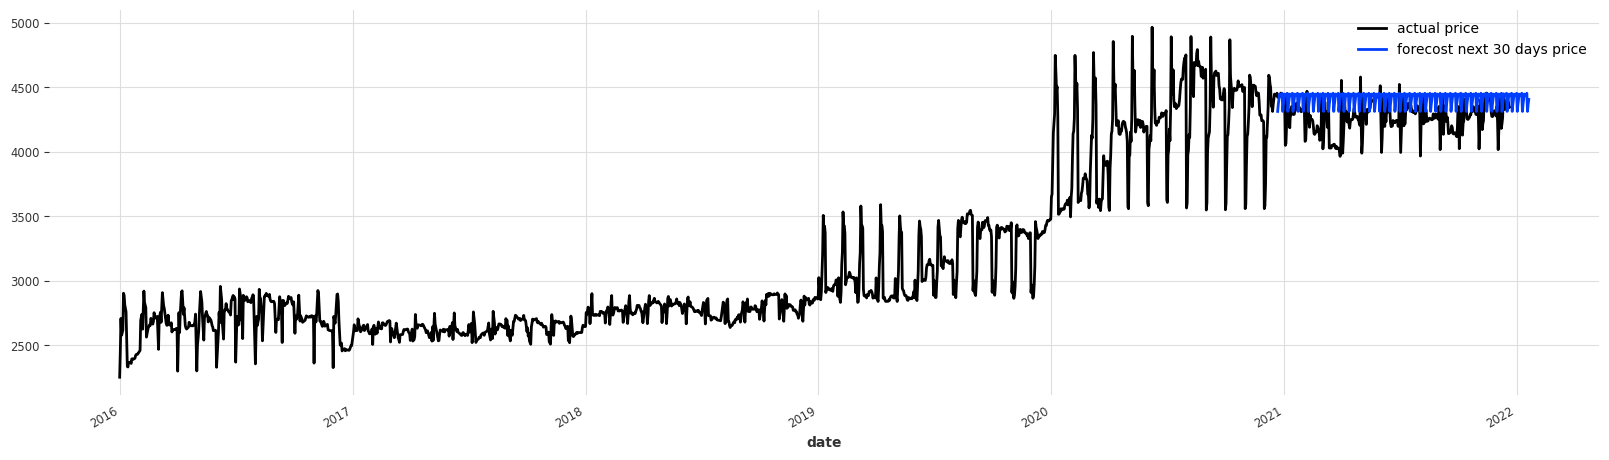

In [52]:
plt.figure(figsize=(20,5))
df_series.plot(label='actual price')
pred_naive.plot(label='forecost next 30 days price')
plt.legend();

In [53]:
rmse_naive=rmse(df_series, pred_naive)
print('RMSE of the gold price = {:.2f}%'.format(rmse_naive))

RMSE of the gold price = 189.29%


# Forecasting NBEATSModel

In [54]:
from darts.models import NBEATSModel
model_nbeats=NBEATSModel(input_chunk_length=24,output_chunk_length=12,n_epochs=100,random_state=42)
model_nbeats.fit(train_gold,verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
49.575    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [55]:
pred=model_nbeats.predict(n=365)

Predicting: 56it [00:00, ?it/s]

In [56]:
forecast= model_nbeats.predict(n=30, series=val_gold)

Predicting: 56it [00:00, ?it/s]

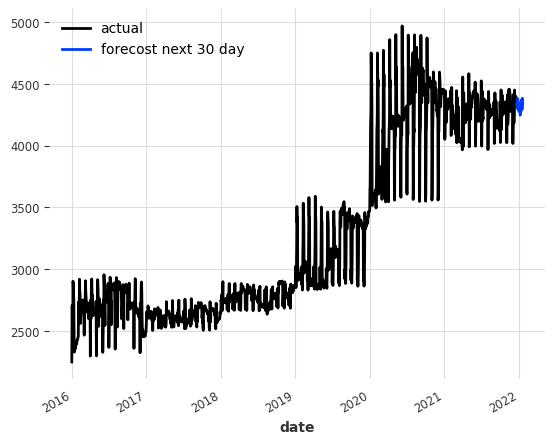

In [57]:
df_series.plot(label='actual')
forecast.plot(label='forecost next 30 day')
plt.legend()

In [58]:
rmse_nbeats=rmse(df_series, pred)
print('RMSE of the gold price = {:.2f}%'.format(rmse_nbeats))

RMSE of the gold price = 366.76%


# xgboost forecasting

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [60]:
dn = pd.read_excel('Gold_data.xlsx')
dn = dn.set_index('date')
dn.index = pd.to_datetime(dn.index)

In [61]:
# create a time series features

def create_features(dn):
    """
    Create time series features based on time series index.
    """
    dn = dn.copy()
    dn['dayofweek'] = dn.index.dayofweek
    dn['quarter'] = dn.index.quarter
    dn['month'] = dn.index.month
    dn['year'] = dn.index.year
    dn['dayofyear'] = dn.index.dayofyear
    dn['dayofmonth'] = dn.index.day
    dn['weekofyear'] = dn.index.isocalendar().week
    return dn

dn = create_features(dn)

In [62]:
# split the data

train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [63]:
# model fitting

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[17:21:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3116.39400	validation_1-rmse:4230.61149
[100]	validation_0-rmse:1156.45413	validation_1-rmse:1599.05564
[200]	validation_0-rmse:452.97530	validation_1-rmse:649.20357
[300]	validation_0-rmse:223.67540	validation_1-rmse:331.55331
[400]	validation_0-rmse:164.42920	validation_1-rmse:247.64231
[500]	validation_0-rmse:147.28048	validation_1-rmse:232.98496
[591]	validation_0-rmse:138.90531	validation_1-rmse:232.95709


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

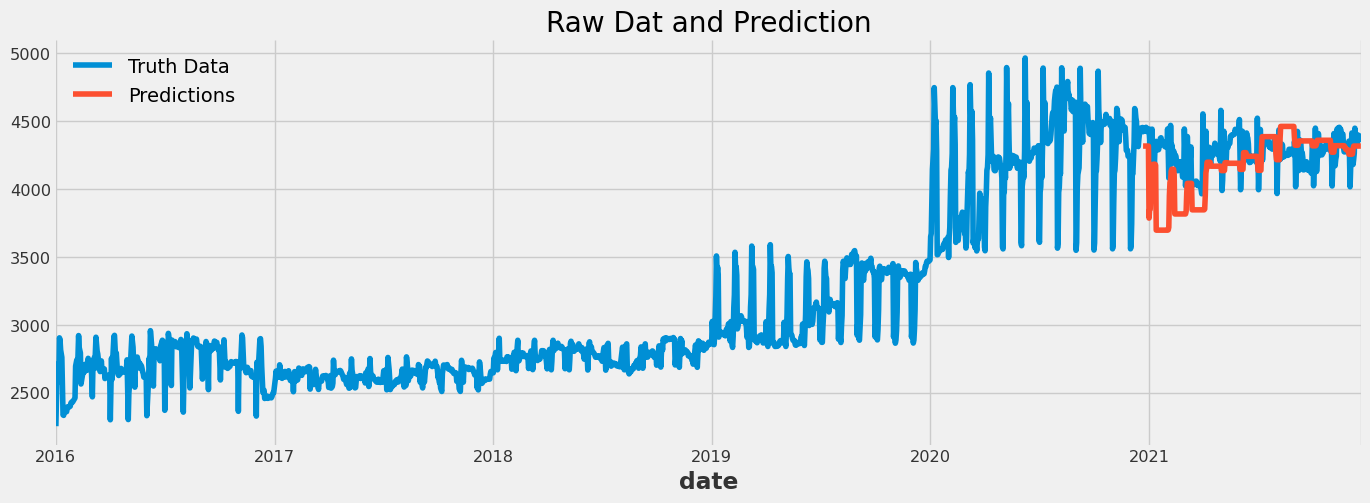

In [64]:
# model predictions
# plot the actual and forecating price

test['prediction'] = reg.predict(X_test)
dn = dn.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = dn[['price']].plot(figsize=(15, 5))
dn['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [65]:
rmse_xgboost = np.sqrt(mean_squared_error(test['price'], test['prediction']))
print(f'RMSE Score on Test set: {rmse_xgboost:0.2f}')

RMSE Score on Test set: 231.89


In [66]:
# Compare the rmse of all forecasting models

data = {"MODEL":pd.Series(["SARIMAX","Prophet","Naive seasonal","NBEATS model",'xgboost forecasting']),
        "RMSE_Values":pd.Series([rmse_sarimax,RMSE_prophet,rmse_naive,rmse_nbeats,rmse_xgboost])}
table=pd.DataFrame(data)
table

MODEL  RMSE_Values
0              SARIMAX   175.559204
1              Prophet   168.822415
2       Naive seasonal   189.291133
3         NBEATS model   366.760619
4  xgboost forecasting   231.885625